# Global Overturning Streamfunction

This scipt plots the global overturning streamfunction in density space for 3 ACCESS-OM2 simulations at different resolutions.

It also serves as a sample for how to compute and display diagnostics for the ACCESS-OM2 model evaluation paper.

In [1]:
%matplotlib inline

import cosima_cookbook as cc
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import pandas as pd
import IPython.display
import cmocean as cm

import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

from dask.distributed import Client

import sys, os

netcdf_index loaded.


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


In [2]:
figdir = ''
def savefigure(fname):
    plt.savefig(os.path.join(figdir, fname+'.png'),dpi=300, bbox_inches="tight")  # comment out to disable saving
    plt.savefig(os.path.join(figdir, fname+'.pdf'),dpi=300, bbox_inches="tight")  # comment out to disable saving
    return

## To deal with memory issues:
* In a terminal on VDI (either over VNC or through SSH and inside screen/tmux), run:
`dask-scheduler`
* This should output the scheduler address, like `tcp://10.0.64.24:8786`. 
* Now, in another terminal (ensuring that the default conda module has cosima_cookbook installed, as all workers will need access to that), run:
`dask-worker tcp://10.0.64.24:8786 --memory-limit 4e9 --nprocs 6 --nthreads 1 --local-directory /local/g40/amh157`
* Then, make sure the following cell matches the scheduler address.

In [3]:
## To implement, use:
## dask-scheduler
## dask-worker tcp://10.0.64.21:8786 --memory-limit 4e9 --nprocs 6 --nthreads 1 --local-directory /local/g40/amh157
client = Client('tcp://10.0.64.21:8786', local_dir='/local/g40/amh157')
client

Client Scheduler: tcp://10.0.64.21:8786 Dashboard: http://10.0.64.21:8787/status,Cluster Workers: 6 Cores: 6 Memory: 24.00 GB


In [8]:
expts = ['01deg_jra55v13_ryf8485_spinup6','01deg_jra55v13_ryf8485_spinup7',
         '01deg_jra55v13_ryf8485_spinup9','01deg_jra55v13_ryf8485_spinup10',
         '01deg_jra55v13_ryf8485_spinup11']

In [4]:
%%time
results = []
for expt in expts:
    psi = cc.get_nc_variable(expt, 'ocean.nc', 'ty_trans_rho',
                          chunks={'potrho': None},n=-8)
    psi = psi.mean('time').sum('grid_xt_ocean')*1.0e-9
    psi_avg = psi.cumsum('potrho') -  psi.sum('potrho')
    psi_avg.load()
    result = {'psi_avg': psi_avg,
                  'expt': expt}
    results.append(result)

Using database sqlite:////g/data3/hh5/tmp/cosima/cosima-cookbook/cosima-cookbook.db
Using database sqlite:////g/data3/hh5/tmp/cosima/cosima-cookbook/cosima-cookbook.db
Using database sqlite:////g/data3/hh5/tmp/cosima/cosima-cookbook/cosima-cookbook.db
Using database sqlite:////g/data3/hh5/tmp/cosima/cosima-cookbook/cosima-cookbook.db
Using database sqlite:////g/data3/hh5/tmp/cosima/cosima-cookbook/cosima-cookbook.db
CPU times: user 1min 36s, sys: 1min 7s, total: 2min 43s
Wall time: 25min 15s


This function plots the streamfunction.

In [5]:
def plot_psi(psi_avg, clev=np.arange(-25,25,2)):

    p1 = plt.contourf(psi_avg.grid_yu_ocean, 
                 psi_avg.potrho, 
                 psi_avg, 
                 cmap=cm.cm.delta,levels=clev,extend='both')
    plt.contour(psi_avg.grid_yu_ocean, 
                psi_avg.potrho, 
                psi_avg, levels=clev, colors='k', linewidths=0.25)
    plt.contour(psi_avg.grid_yu_ocean,
                psi_avg.potrho, psi_avg,
                levels=[0.0,], colors='k', linewidths=0.5)
    plt.gca().invert_yaxis()
    
    plt.ylim((1037.5,1034))
    plt.ylabel('Potential Density (kg m$^{-3}$)')
    plt.xlabel('Latitude ($^\circ$N)')
    plt.xlim([-75,85])
    
    return p1

And here is the code to make the actual figure.

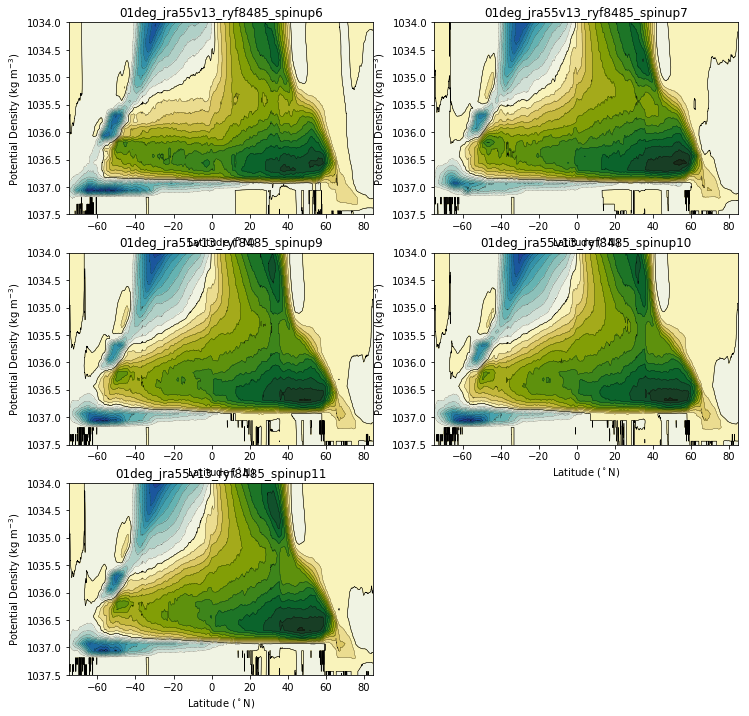

In [6]:
plt.figure(figsize=(12,12))
clev=np.arange(-26,26.01,2)
ii=1
for result in results:
    psi_avg = result['psi_avg']
    expt = result['expt']
    plt.subplot(3,2,ii)
    p1 = plot_psi(psi_avg,clev)
    plt.title(expt)
    ii+=1
    

In [13]:
%%time
results = []
for expt in expts:
    psi = cc.get_nc_variable(expt, 'ocean.nc', 'ty_trans_rho',
                          chunks={'potrho': None},n=350)
    psi_aabw = psi.sum('grid_xt_ocean').sel(method='Nearest',grid_yu_ocean=-55)*1.0e-9
    psi_aabw_sum = psi_aabw.cumsum('potrho') - psi_aabw.sum('potrho')
    psi_aabw_sum = -psi_aabw_sum.sel(potrho=slice(1036.2,None)).min('potrho').resample(time='A').mean('time').load()
    result = {'psi_aabw': psi_aabw_sum,
                  'expt': expt}
    results.append(result)
    

Using database sqlite:////g/data3/hh5/tmp/cosima/cosima-cookbook/cosima-cookbook.db
Using database sqlite:////g/data3/hh5/tmp/cosima/cosima-cookbook/cosima-cookbook.db
Using database sqlite:////g/data3/hh5/tmp/cosima/cosima-cookbook/cosima-cookbook.db
Using database sqlite:////g/data3/hh5/tmp/cosima/cosima-cookbook/cosima-cookbook.db
Using database sqlite:////g/data3/hh5/tmp/cosima/cosima-cookbook/cosima-cookbook.db
CPU times: user 1min 47s, sys: 1min 5s, total: 2min 53s
Wall time: 13min 1s


Text(0.5, 1.0, 'AABW Overturning Cell at 55S')

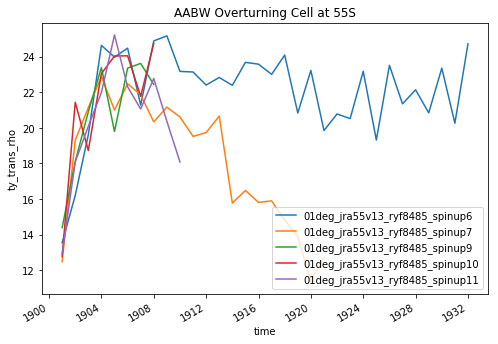

In [14]:
plt.figure(figsize=(8,5))
for result in results:
    psi_aabw = result['psi_aabw']
    expt = result['expt']
    psi_aabw.plot(label=expt)
    
plt.legend()
plt.title('AABW Overturning Cell at 55S')

In [15]:
%%time
results = []
for expt in expts:
    psi = cc.get_nc_variable(expt, 'ocean.nc', 'ty_trans_rho',
                          chunks={'potrho': None},n=350)
    psi_amoc = psi.sel(grid_xt_ocean=slice(-103,-5)).sum('grid_xt_ocean').sel(method='Nearest',grid_yu_ocean=26)*1.0e-9
    psi_amoc_sum = psi_amoc.cumsum('potrho') - psi_amoc.sum('potrho')
    psi_amoc_sum = psi_amoc_sum.sel(potrho=slice(1035.5,None)).max('potrho').resample(time='A').mean('time')
    result = {'psi_amoc': psi_amoc_sum,
                  'expt': expt}
    results.append(result)

Using database sqlite:////g/data3/hh5/tmp/cosima/cosima-cookbook/cosima-cookbook.db
Using database sqlite:////g/data3/hh5/tmp/cosima/cosima-cookbook/cosima-cookbook.db
Using database sqlite:////g/data3/hh5/tmp/cosima/cosima-cookbook/cosima-cookbook.db
Using database sqlite:////g/data3/hh5/tmp/cosima/cosima-cookbook/cosima-cookbook.db
Using database sqlite:////g/data3/hh5/tmp/cosima/cosima-cookbook/cosima-cookbook.db
CPU times: user 1min 36s, sys: 1min 7s, total: 2min 43s
Wall time: 3min 32s


Text(0.5, 1.0, 'AMOC Overturning')

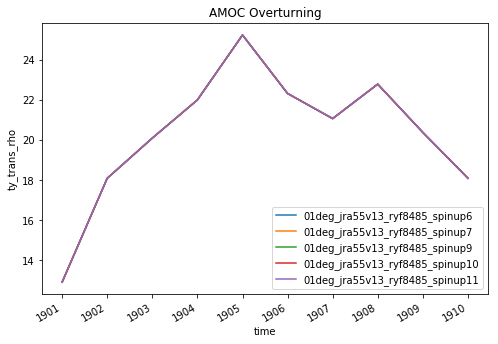

In [16]:
plt.figure(figsize=(8,5))
for result in results:
    psi_amoc = result['psi_amoc']
    expt = result['expt']
    psi_aabw.plot(label=expt)
    
plt.legend()
plt.title('AMOC Overturning')

In [18]:
results

[{'psi_amoc': <xarray.DataArray 'ty_trans_rho' (time: 32)>
  dask.array<shape=(32,), dtype=float32, chunksize=(1,)>
  Coordinates:
    * time           (time) datetime64[ns] 1900-12-31 1901-12-31 ... 1931-12-31
      grid_yu_ocean  float64 25.96, 'expt': '01deg_jra55v13_ryf8485_spinup6'},
 {'psi_amoc': <xarray.DataArray 'ty_trans_rho' (time: 21)>
  dask.array<shape=(21,), dtype=float32, chunksize=(1,)>
  Coordinates:
    * time           (time) datetime64[ns] 1900-12-31 1901-12-31 ... 1920-12-31
      grid_yu_ocean  float64 25.96, 'expt': '01deg_jra55v13_ryf8485_spinup7'},
 {'psi_amoc': <xarray.DataArray 'ty_trans_rho' (time: 8)>
  dask.array<shape=(8,), dtype=float32, chunksize=(1,)>
  Coordinates:
    * time           (time) datetime64[ns] 1900-12-31 1901-12-31 ... 1907-12-31
      grid_yu_ocean  float64 25.96, 'expt': '01deg_jra55v13_ryf8485_spinup9'},
 {'psi_amoc': <xarray.DataArray 'ty_trans_rho' (time: 8)>
  dask.array<shape=(8,), dtype=float32, chunksize=(1,)>
  Coordinates:
   